# NSA Motor Guarantee — Claims Exploratory Data Analysis

**84 claims** across 3 datasets (4 seed + 50 eval-v1 + 30 eval-v2)  
**Goal:** Surface patterns in volume, money, denial reasons, and segments to identify high-leverage opportunities.

---

In [1]:
import json, re, pathlib
from collections import Counter
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 110

DATA_ROOT = pathlib.Path("../data/datasets")
print("Data root:", DATA_ROOT.resolve())

Data root: C:\Users\fbrun\Documents\GitHub\AgenticContextBuilder\data\datasets


## 1. Load & Normalize All Datasets

The 3 datasets use slightly different schemas. We normalize into a single DataFrame with a common set of columns.

In [2]:
def load_ground_truth(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

gt_seed = load_ground_truth(DATA_ROOT / "nsa-motor-seed-v1/ground_truth.json")
gt_eval1 = load_ground_truth(DATA_ROOT / "nsa-motor-eval-v1/ground_truth.json")
gt_eval2 = load_ground_truth(DATA_ROOT / "nsa-motor-eval-v2/ground_truth.json")

print(f"Seed:   {len(gt_seed['claims'])} claims")
print(f"Eval-1: {len(gt_eval1['claims'])} claims")
print(f"Eval-2: {len(gt_eval2['claims'])} claims")
print(f"Total:  {len(gt_seed['claims']) + len(gt_eval1['claims']) + len(gt_eval2['claims'])} claims")

Seed:   4 claims
Eval-1: 50 claims
Eval-2: 30 claims
Total:  84 claims


In [3]:
def normalize_claim(claim, dataset):
    """Map each dataset's schema to a common set of columns."""
    row = {
        "claim_id": str(claim["claim_id"]),
        "dataset": dataset,
        "decision": claim["decision"],
        "denial_reason": claim.get("denial_reason"),
        "vehicle": claim.get("vehicle"),
        "guarantee_number": claim.get("guarantee_number"),
        "currency": claim.get("currency", "CHF"),
    }

    # --- amounts (field names differ across datasets) ---
    row["total_approved_amount"] = claim.get("total_approved_amount") or claim.get("approved_amount")
    row["deductible"] = claim.get("deductible")
    row["parts_approved"] = claim.get("parts_approved")
    row["labor_approved"] = claim.get("labor_approved")
    row["total_material_labor"] = claim.get("total_material_labor_approved")
    row["total_estimate"] = claim.get("total_amount") or claim.get("total_material_labor_estimate")
    row["reimbursement_rate_pct"] = claim.get("reimbursement_rate_pct")
    row["vat_rate_pct"] = claim.get("vat_rate_pct")

    # --- coverage / notes ---
    row["coverage_notes"] = claim.get("coverage_notes")

    # --- language ---
    row["language"] = claim.get("language")

    # --- date (various formats) ---
    raw_date = claim.get("date")
    if raw_date:
        for fmt in ("%d/%m/%Y", "%d.%m.%Y"):
            try:
                row["date"] = datetime.strptime(raw_date, fmt)
                break
            except ValueError:
                continue
    if "date" not in row:
        row["date"] = None

    # --- garage ---
    if isinstance(claim.get("garage"), dict):
        row["garage_name"] = claim["garage"].get("name")
        row["garage_city"] = claim["garage"].get("city")
    else:
        row["garage_name"] = claim.get("garage_name")
        row["garage_city"] = claim.get("garage_city")

    # --- decision_type (seed only) ---
    row["decision_type"] = claim.get("decision_type")

    return row


rows = []
for c in gt_seed["claims"]:
    rows.append(normalize_claim(c, "seed-v1"))
for c in gt_eval1["claims"]:
    rows.append(normalize_claim(c, "eval-v1"))
for c in gt_eval2["claims"]:
    rows.append(normalize_claim(c, "eval-v2"))

df = pd.DataFrame(rows)
print(f"Combined DataFrame: {len(df)} rows x {len(df.columns)} cols")
df.head()

Combined DataFrame: 84 rows x 21 cols


,claim_id,dataset,decision,denial_reason,vehicle,guarantee_number,currency,total_approved_amount,deductible,parts_approved,...,total_material_labor,total_estimate,reimbursement_rate_pct,vat_rate_pct,coverage_notes,language,date,garage_name,garage_city,decision_type
0,65196,seed-v1,APPROVED,None,Audi RS4 Avant,612166,CHF,1688.82,204.70,NaN,...,1893.52,2366.90,80.0,8.1,Gewährleistungspflichtige Materialkosten und A...,de,2026-01-14,AMAG AUTOMOBIL UND MOTOREN AG,Bern,partial_approval
1,65258,seed-v1,APPROVED,None,Mercedes A 220 AMG Line 7G-DCT 4Matic,624465,CHF,4500.00,500.00,NaN,...,4625.35,4625.35,NaN,8.1,Maximum coverage per policy applied (Zylinderk...,de,2026-01-20,Kestenholz Automobil AG,Oberwil,maximum_coverage
2,65157,seed-v1,DENIED,Laut Aussage des Versicherungsnehmers hat sich...,Volkswagen Golf 2.0 TSI GTI,625928,CHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,de,2026-01-21,AUTORAMA AG,Wetzikon,outside_insured_period
3,65128,seed-v1,DENIED,La garantie couvre uniquement les pièces menti...,Cupra Formentor,590223,CHF,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,fr,2026-01-08,AMAG Automobiles et Moteurs SA,Noville,part_not_covered
4,64166,eval-v1,APPROVED,None,Ford FOCUS,599489,CHF,1506.52,376.65,1270.0,...,1742.07,NaN,NaN,8.1,L'unite processseur. la recherche de panne et ...,fr,2025-10-08,BYMYCAR GLAND,Gland,None


In [4]:
# --- Derive vehicle brand from vehicle string ---
BRAND_MAP = {
    "alfa romeo": "Alfa Romeo",
    "audi": "Audi",
    "bentley": "Bentley",
    "bmw": "BMW",
    "citroen": "Citroën",
    "citroën": "Citroën",
    "cupra": "Cupra",
    "fiat": "Fiat",
    "ford": "Ford",
    "hyundai": "Hyundai",
    "jeep": "Jeep",
    "land rover": "Land Rover",
    "mercedes": "Mercedes",
    "mini": "Mini",
    "mitsubishi": "Mitsubishi",
    "nissan": "Nissan",
    "peugeot": "Peugeot",
    "porsche": "Porsche",
    "renault": "Renault",
    "rolls royce": "Rolls-Royce",
    "rolls-royce": "Rolls-Royce",
    "seat": "Seat",
    "skoda": "Skoda",
    "subaru": "Subaru",
    "volkswagen": "Volkswagen",
    "vw": "Volkswagen",
}

def extract_brand(vehicle_str):
    if not vehicle_str:
        return "Unknown"
    v = vehicle_str.lower().strip()
    # Check longer brand names first to avoid false matches
    for key in sorted(BRAND_MAP, key=len, reverse=True):
        if v.startswith(key):
            return BRAND_MAP[key]
    # Fallback: first word
    return vehicle_str.split()[0].title() if vehicle_str else "Unknown"

df["brand"] = df["vehicle"].apply(extract_brand)

# Quick check
print("Brands found:", sorted(df["brand"].unique()))
print(f"\n{df['brand'].value_counts().to_string()}")

Brands found: ['Alfa Romeo', 'Audi', 'BMW', 'Bentley', 'Citroën', 'Cupra', 'Fiat', 'Ford', 'Hyundai', 'Jeep', 'Land Rover', 'Mercedes', 'Mini', 'Mitsubishi', 'Nissan', 'Peugeot', 'Porsche', 'Renault', 'Rolls-Royce', 'Seat', 'Skoda', 'Subaru', 'Volkswagen']

brand
Volkswagen     16
Mercedes       14
Audi            8
Land Rover      7
BMW             7
Peugeot         6
Ford            4
Mini            3
Cupra           2
Seat            2
Jeep            2
Porsche         2
Subaru          1
Alfa Romeo      1
Rolls-Royce     1
Hyundai         1
Mitsubishi      1
Citroën         1
Bentley         1
Renault         1
Fiat            1
Nissan          1
Skoda           1


## 2. Overview & Decision Distribution

High-level: how many claims, approve vs deny, by dataset.

=== Overall Decision Split ===
  APPROVED: 42  (50%)
  DENIED: 42  (50%)

=== By Dataset ===
decision  APPROVED  DENIED  All
dataset                        
eval-v1         25      25   50
eval-v2         15      15   30
seed-v1          2       2    4
All             42      42   84


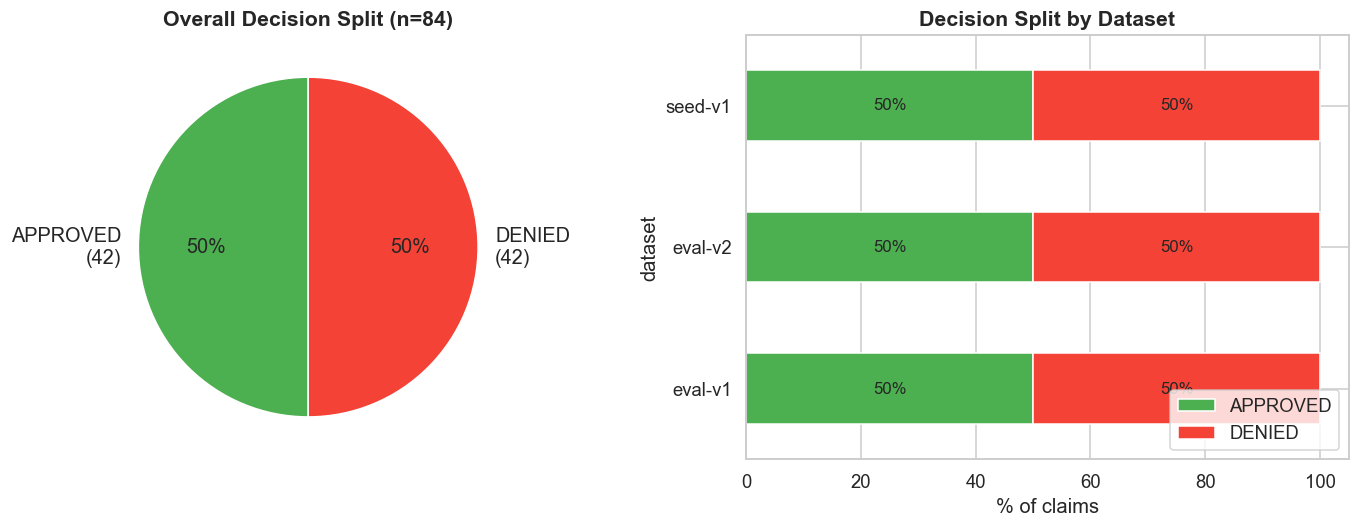

In [5]:
# --- Overall decision split ---
decision_counts = df["decision"].value_counts()
print("=== Overall Decision Split ===")
for d, c in decision_counts.items():
    print(f"  {d}: {c}  ({c/len(df)*100:.0f}%)")

print(f"\n=== By Dataset ===")
ct = pd.crosstab(df["dataset"], df["decision"], margins=True)
print(ct)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Pie chart - overall
colors = {"APPROVED": "#4CAF50", "DENIED": "#F44336"}
axes[0].pie(
    decision_counts.values,
    labels=[f"{k}\n({v})" for k, v in decision_counts.items()],
    colors=[colors[k] for k in decision_counts.index],
    autopct="%1.0f%%",
    startangle=90,
    textprops={"fontsize": 13},
)
axes[0].set_title("Overall Decision Split (n=84)", fontsize=14, fontweight="bold")

# Stacked bar by dataset
ct_pct = pd.crosstab(df["dataset"], df["decision"], normalize="index") * 100
ct_pct[["APPROVED", "DENIED"]].plot.barh(
    stacked=True, color=[colors["APPROVED"], colors["DENIED"]], ax=axes[1], edgecolor="white"
)
axes[1].set_xlabel("% of claims")
axes[1].set_title("Decision Split by Dataset", fontsize=14, fontweight="bold")
axes[1].legend(loc="lower right")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.0f%%", label_type="center", fontsize=11)

plt.tight_layout()
plt.show()

## 3. Denial Reason Taxonomy

Cluster free-text denial reasons (DE/FR) into actionable categories. This reveals *why* claims fail.

=== Denial Reason Categories ===
  Part not covered: 32  (76%)
  Policy not valid / expired: 4  (10%)
  Consequential / root-cause damage: 4  (10%)
  Wear parts excluded: 1  (2%)
  Mileage exclusion: 1  (2%)


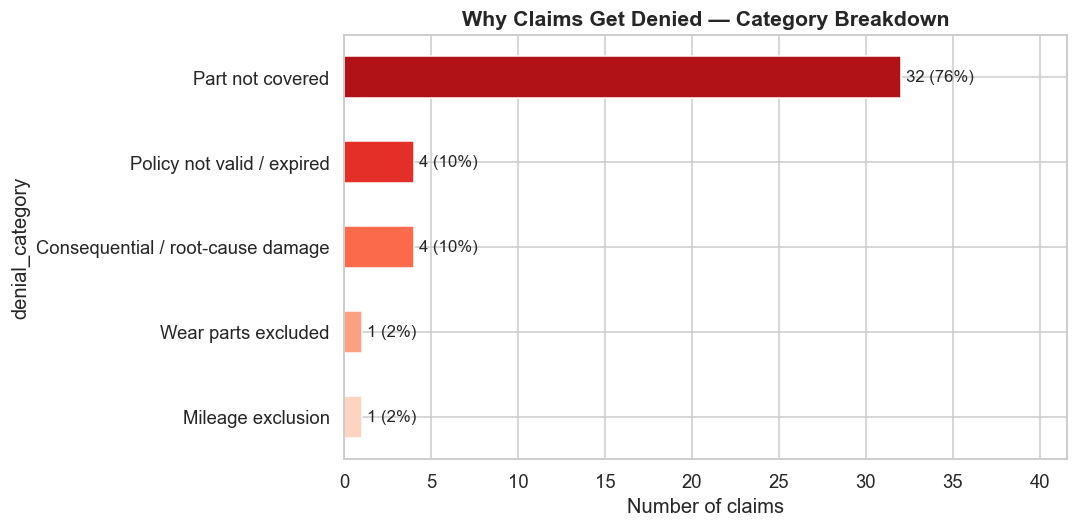

In [6]:
# --- Classify denial reasons into categories ---
denied = df[df["decision"] == "DENIED"].copy()

def classify_denial(reason):
    """Classify a denial reason string into a high-level category."""
    if not reason:
        return "Unknown"
    r = reason.lower()

    # Policy validity issues
    if any(kw in r for kw in [
        "police n'est pas valide", "garantie est échue", "limite de kilométrage",
        "ausserhalb der versicherten periode", "nicht valide", "non-payment",
        "premium", "prämie", "lapses", "nicht gültig",
    ]):
        return "Policy not valid / expired"

    if any(kw in r for kw in [
        "non-payment", "nichtzahlung", "non paiement", "lapses",
    ]):
        return "Premium unpaid"

    # Mileage-based exclusion
    if any(kw in r for kw in [
        "above 100,000 km", "ab 100.000 km", "no coverage for the following components above",
    ]):
        return "Mileage exclusion"

    # Consequential / root-cause damage
    if any(kw in r for kw in [
        "folgeschäden", "dommages causés", "consequential", "distribution",
        "caused by",
    ]):
        return "Consequential / root-cause damage"

    # Wear parts
    if any(kw in r for kw in [
        "wear part", "verschleissteil", "usure",
        "brake disc", "brake pad", "bremsscheib", "bremsbelag",
    ]):
        return "Wear parts excluded"

    # Part not covered (most common — catch-all for "Teile nicht versichert")
    if any(kw in r for kw in [
        "nicht über die garantie versichert", "nicht von der garantie",
        "nicht über die garantie abgedeckt", "nicht abgedeckt",
        "nicht versichert", "keine kosten",
        "n'est pas couvert", "ne sont pas couvert",
        "not covered", "nur die teile", "only covers parts",
        "uniquement les pièces", "ausschliesslich die teile",
        "only parts listed", "only parts declared", "only parts mentioned",
        "explicitly excluded", "explicitement exclu",
    ]):
        return "Part not covered"

    # Malfunction caused by non-insured part
    if any(kw in r for kw in [
        "non-insured part", "nicht versichertes teil",
        "non insured", "malfunction is caused by a non",
    ]):
        return "Malfunction from non-insured part"

    return "Other"


denied["denial_category"] = denied["denial_reason"].apply(classify_denial)

cat_counts = denied["denial_category"].value_counts()
print("=== Denial Reason Categories ===")
for cat, cnt in cat_counts.items():
    print(f"  {cat}: {cnt}  ({cnt/len(denied)*100:.0f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
cat_counts.plot.barh(ax=ax, color=sns.color_palette("Reds_r", len(cat_counts)), edgecolor="white")
ax.set_xlabel("Number of claims")
ax.set_title("Why Claims Get Denied — Category Breakdown", fontsize=14, fontweight="bold")
ax.invert_yaxis()
for i, (v, cat) in enumerate(zip(cat_counts.values, cat_counts.index)):
    ax.text(v + 0.3, i, f"{v} ({v/len(denied)*100:.0f}%)", va="center", fontsize=11)
ax.set_xlim(0, cat_counts.max() * 1.3)
plt.tight_layout()
plt.show()

## 4. Denied Parts Inventory

Extract and count the specific parts/components mentioned in denial reasons. This is a direct coverage-gap analysis.

In [7]:
# --- Extract denied parts from denial reason text ---
# Normalize DE/FR part names to English for consistent counting

PART_PATTERNS = {
    # Sensors
    r"scheinwerfer|headlight": "Headlights",
    r"querlenker|control arm|bras de suspension|suspension arm": "Control arm / suspension arm",
    r"parktikelfilter.?sensor|dpf.?sensor": "DPF / particle filter sensor",
    r"nox.?sensor": "NOx sensor",
    r"kabelbaum|wiring harness|faisceau": "Wiring harness",
    r"motorsteuergerät|control unit|calculateur": "Engine control unit (ECU)",
    r"heizungsventil|heating valve": "Heating valve",
    r"kühlsystem|cooling system|refroidiss": "Cooling system",
    r"hochdruckpumpe|high.?pressure pump|pompe haute pression": "High-pressure pump",
    r"zahnriemen|timing belt|courroie de distribution": "Timing belt",
    r"ad.?blue|harnstoff": "AdBlue system / urea tank",
    r"software.?update": "Software update",
    r"lenkrad|steering wheel|volant": "Steering wheel",
    r"wasserpumpe|water pump|pompe.+eau": "Water pump",
    r"filtre.+huile|ölfilter|oil filter support|support du filtre": "Oil filter support / housing",
    r"couvre.?culasse|couvercle de soupape|valve cover|ventildeckel": "Valve cover / rocker cover",
    r"gaines? d.?etancheite|dichtung|gasket|seal|joint": "Gaskets / seals",
    r"egr|recirculation des gaz|abgasrückführ": "EGR valve / system",
    r"seuil|threshold|schweller": "Door sill / threshold",
    r"serrure|lock|schloss": "Lock (trunk/door)",
    r"turbo|compressor|intercooler|lader": "Turbo / compressor / intercooler",
    r"hybrid|batterie|battery": "Hybrid system / battery",
    r"parking.?sensor|einparkhilfe|capteur de stationnement": "Parking sensors",
    r"brake disc|brake pad|bremsscheib|bremsbelag|frein": "Brake discs / pads",
    r"hose|schlauch|flexible|tuyau": "Hoses",
    r"exhaust gas temperature|abgastemperatur": "Exhaust gas temp sensor",
    r"masse? air flow|luftmass": "Mass airflow sensor",
    r"cruise control|tempomat|régulateur": "Cruise control",
    r"rocker arm|culbuteur|kipphebel": "Rocker arms",
    r"camshaft|nockenwelle|arbre à cames": "Camshaft adjustment",
    r"hydraulic tappet|hydrostössel": "Hydraulic tappets",
    r"vilebrequin|crankshaft|kurbelwelle": "Crankshaft seal",
    r"carter de distribution": "Timing cover gasket",
}

def extract_denied_parts(reason):
    """Return list of normalized part names found in a denial reason string."""
    if not reason:
        return []
    r = reason.lower()
    found = []
    for pattern, part_name in PART_PATTERNS.items():
        if re.search(pattern, r):
            found.append(part_name)
    return found

denied["denied_parts"] = denied["denial_reason"].apply(extract_denied_parts)

# Flatten and count
all_parts = []
for parts in denied["denied_parts"]:
    all_parts.extend(parts)

part_counter = Counter(all_parts)
part_df = pd.DataFrame(part_counter.most_common(), columns=["part", "count"])

print(f"=== Denied Parts — Top 20 ===")
print(f"(extracted from {len(denied)} denial reasons)\n")
print(part_df.head(20).to_string(index=False))

# Show claims where no parts could be extracted (for review)
no_parts = denied[denied["denied_parts"].apply(len) == 0]
if len(no_parts) > 0:
    print(f"\n--- {len(no_parts)} denials with no part extracted ---")
    for _, row in no_parts.iterrows():
        print(f"  {row['claim_id']}: {row['denial_reason'][:100]}...")

=== Denied Parts — Top 20 ===
(extracted from 42 denial reasons)

                        part  count
             Software update      3
             Gaskets / seals      3
          EGR valve / system      3
Control arm / suspension arm      2
              Wiring harness      2
   Engine control unit (ECU)      2
              Cooling system      2
   AdBlue system / urea tank      2
                 Timing belt      2
              Steering wheel      2
                  Water pump      2
  Valve cover / rocker cover      2
     Hybrid system / battery      2
           Lock (trunk/door)      1
                  Headlights      1
DPF / particle filter sensor      1
                  NOx sensor      1
               Heating valve      1
             Crankshaft seal      1
         Timing cover gasket      1

--- 6 denials with no part extracted ---
  65157: Laut Aussage des Versicherungsnehmers hat sich der Schaden erstmals am 29. Dezember 2025 bemerkbar g...
  64980: Rectification 

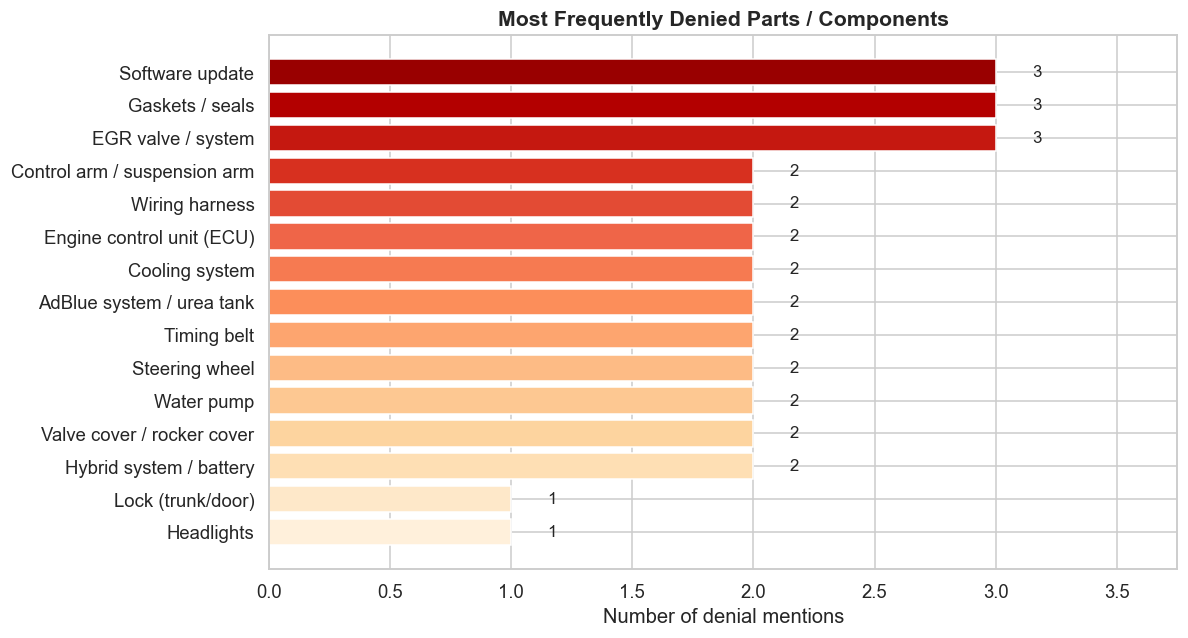


=== Denied Parts by System Category ===
                system  count
Electronics / Software     10
             Emissions      8
       Seals & Gaskets      8
   Engine / Powertrain      8
     Cooling / Heating      5
    Chassis / Steering      4
       Body / Exterior      2
            Wear parts      2
           Hybrid / EV      2


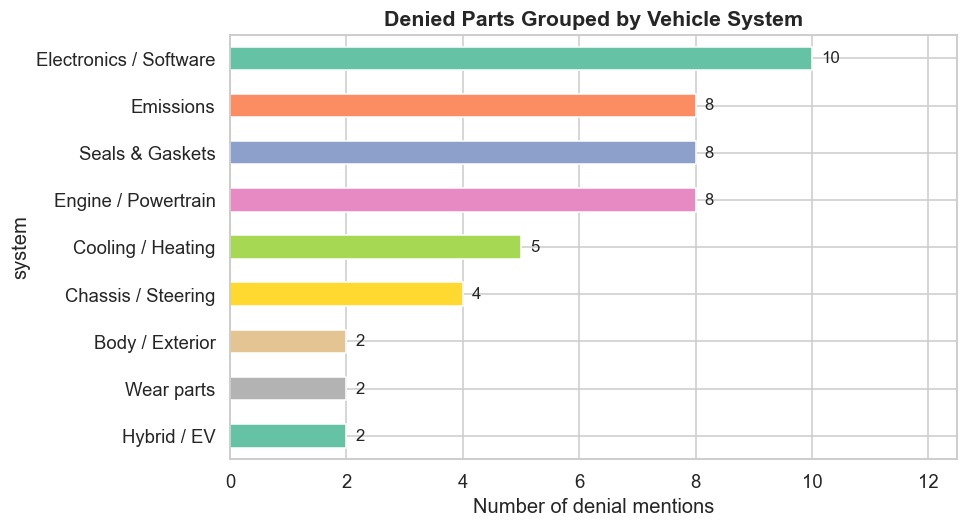

In [8]:
# --- Denied parts chart ---
top_parts = part_df.head(15)

fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.barh(
    range(len(top_parts)),
    top_parts["count"],
    color=sns.color_palette("OrRd_r", len(top_parts)),
    edgecolor="white",
)
ax.set_yticks(range(len(top_parts)))
ax.set_yticklabels(top_parts["part"])
ax.invert_yaxis()
ax.set_xlabel("Number of denial mentions")
ax.set_title("Most Frequently Denied Parts / Components", fontsize=14, fontweight="bold")

for i, v in enumerate(top_parts["count"]):
    ax.text(v + 0.15, i, str(v), va="center", fontsize=11)
ax.set_xlim(0, top_parts["count"].max() * 1.25)

plt.tight_layout()
plt.show()

# --- Group denied parts into system categories ---
SYSTEM_MAP = {
    "EGR valve / system": "Emissions",
    "AdBlue system / urea tank": "Emissions",
    "DPF / particle filter sensor": "Emissions",
    "Exhaust gas temp sensor": "Emissions",
    "NOx sensor": "Emissions",
    "Gaskets / seals": "Seals & Gaskets",
    "Crankshaft seal": "Seals & Gaskets",
    "Timing cover gasket": "Seals & Gaskets",
    "Valve cover / rocker cover": "Seals & Gaskets",
    "Oil filter support / housing": "Seals & Gaskets",
    "Software update": "Electronics / Software",
    "Wiring harness": "Electronics / Software",
    "Engine control unit (ECU)": "Electronics / Software",
    "Cruise control": "Electronics / Software",
    "Parking sensors": "Electronics / Software",
    "Headlights": "Electronics / Software",
    "Turbo / compressor / intercooler": "Engine / Powertrain",
    "Timing belt": "Engine / Powertrain",
    "High-pressure pump": "Engine / Powertrain",
    "Rocker arms": "Engine / Powertrain",
    "Camshaft adjustment": "Engine / Powertrain",
    "Hydraulic tappets": "Engine / Powertrain",
    "Mass airflow sensor": "Engine / Powertrain",
    "Water pump": "Cooling / Heating",
    "Heating valve": "Cooling / Heating",
    "Cooling system": "Cooling / Heating",
    "Control arm / suspension arm": "Chassis / Steering",
    "Steering wheel": "Chassis / Steering",
    "Brake discs / pads": "Wear parts",
    "Hoses": "Wear parts",
    "Door sill / threshold": "Body / Exterior",
    "Lock (trunk/door)": "Body / Exterior",
    "Hybrid system / battery": "Hybrid / EV",
}

system_counter = Counter()
for part, count in part_counter.items():
    system = SYSTEM_MAP.get(part, "Other")
    system_counter[system] += count

system_df = pd.DataFrame(system_counter.most_common(), columns=["system", "count"])
print("\n=== Denied Parts by System Category ===")
print(system_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(9, 5))
system_df.plot.barh(x="system", y="count", ax=ax, legend=False,
                    color=sns.color_palette("Set2", len(system_df)), edgecolor="white")
ax.invert_yaxis()
ax.set_xlabel("Number of denial mentions")
ax.set_title("Denied Parts Grouped by Vehicle System", fontsize=14, fontweight="bold")
for i, v in enumerate(system_df["count"]):
    ax.text(v + 0.15, i, str(v), va="center", fontsize=11)
ax.set_xlim(0, system_df["count"].max() * 1.25)
plt.tight_layout()
plt.show()

## 5. Approved Claims — Financial Analysis

Distribution of approved amounts, deductibles, reimbursement tiers, and parts-vs-labor split.

=== Approved Claims Financial Summary ===
Approved claims with amount data: 42 / 42

Total Approved Amount (CHF):
count      42.00
mean     1449.63
std      1231.74
min        24.98
25%       531.20
50%       948.57
75%      2274.54
max      4500.00

Sum of all approved amounts: CHF 60,884.55
Mean approved amount:        CHF 1,449.63
Median approved amount:      CHF 948.57


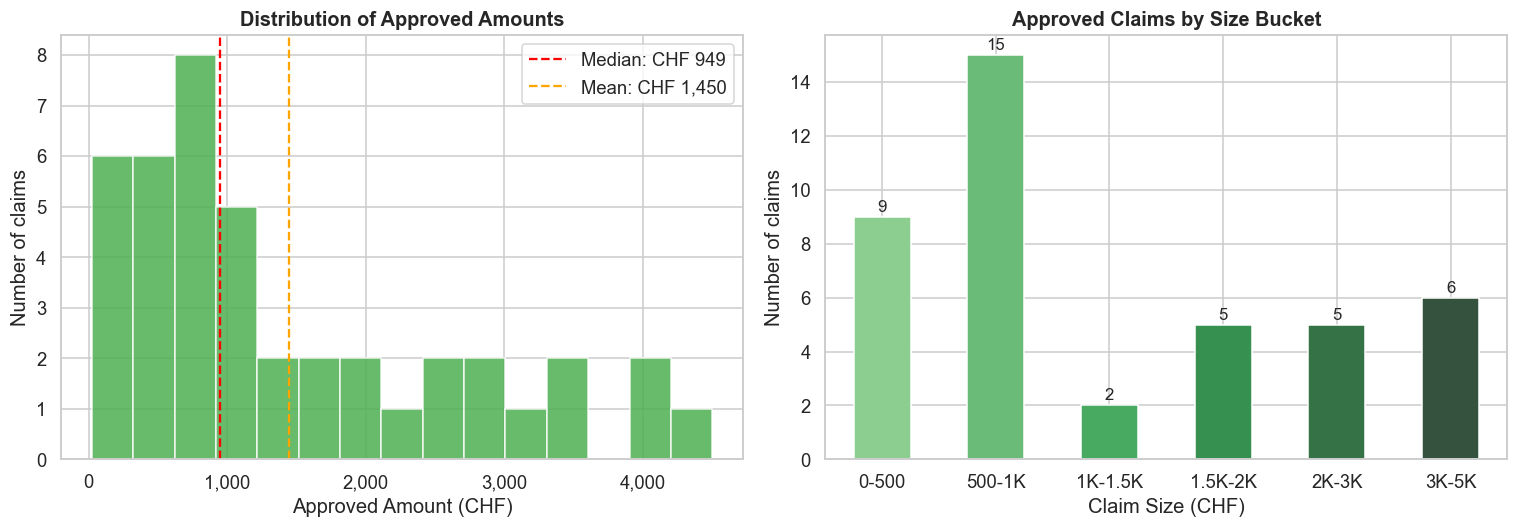

In [9]:
approved = df[df["decision"] == "APPROVED"].copy()
has_amount = approved[approved["total_approved_amount"].notna()].copy()

print(f"=== Approved Claims Financial Summary ===")
print(f"Approved claims with amount data: {len(has_amount)} / {len(approved)}")
print(f"\nTotal Approved Amount (CHF):")
print(has_amount["total_approved_amount"].describe().round(2).to_string())
print(f"\nSum of all approved amounts: CHF {has_amount['total_approved_amount'].sum():,.2f}")
print(f"Mean approved amount:        CHF {has_amount['total_approved_amount'].mean():,.2f}")
print(f"Median approved amount:      CHF {has_amount['total_approved_amount'].median():,.2f}")

# --- Amount distribution histogram ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(has_amount["total_approved_amount"], bins=15, color="#4CAF50", edgecolor="white", alpha=0.85)
axes[0].axvline(has_amount["total_approved_amount"].median(), color="red", linestyle="--", label=f'Median: CHF {has_amount["total_approved_amount"].median():,.0f}')
axes[0].axvline(has_amount["total_approved_amount"].mean(), color="orange", linestyle="--", label=f'Mean: CHF {has_amount["total_approved_amount"].mean():,.0f}')
axes[0].set_xlabel("Approved Amount (CHF)")
axes[0].set_ylabel("Number of claims")
axes[0].set_title("Distribution of Approved Amounts", fontsize=13, fontweight="bold")
axes[0].legend()
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# --- Claim size buckets ---
bins = [0, 500, 1000, 1500, 2000, 3000, 5000]
labels = ["0-500", "500-1K", "1K-1.5K", "1.5K-2K", "2K-3K", "3K-5K"]
has_amount["size_bucket"] = pd.cut(has_amount["total_approved_amount"], bins=bins, labels=labels, right=True)
bucket_counts = has_amount["size_bucket"].value_counts().sort_index()

bucket_counts.plot.bar(ax=axes[1], color=sns.color_palette("Greens_d", len(bucket_counts)), edgecolor="white")
axes[1].set_xlabel("Claim Size (CHF)")
axes[1].set_ylabel("Number of claims")
axes[1].set_title("Approved Claims by Size Bucket", fontsize=13, fontweight="bold")
axes[1].tick_params(axis='x', rotation=0)
for i, v in enumerate(bucket_counts.values):
    axes[1].text(i, v + 0.2, str(v), ha="center", fontsize=11)

plt.tight_layout()
plt.show()

=== Deductible Distribution ===
count     41.00
mean     208.14
std      113.83
min        0.00
25%      150.00
50%      150.00
75%      269.95
max      500.00

Most common deductibles:
deductible
150.00    20
204.70     1
500.00     1
376.65     1
460.10     1
269.95     1
314.40     1
266.40     1
332.80     1
434.90     1


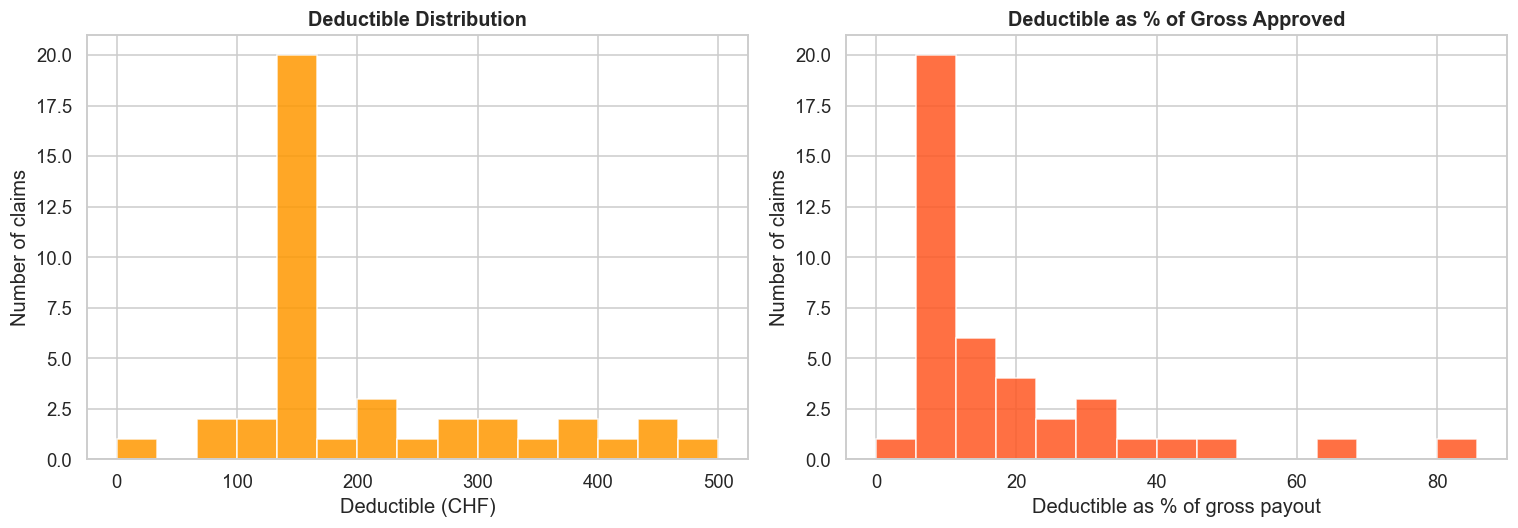

In [10]:
# --- Deductible analysis ---
has_deductible = has_amount[has_amount["deductible"].notna()]
print("=== Deductible Distribution ===")
print(has_deductible["deductible"].describe().round(2).to_string())
print(f"\nMost common deductibles:")
print(has_deductible["deductible"].value_counts().head(10).to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(has_deductible["deductible"], bins=15, color="#FF9800", edgecolor="white", alpha=0.85)
axes[0].set_xlabel("Deductible (CHF)")
axes[0].set_ylabel("Number of claims")
axes[0].set_title("Deductible Distribution", fontsize=13, fontweight="bold")

# --- Deductible as % of approved amount ---
has_deductible = has_deductible.copy()
has_deductible["deductible_pct"] = (
    has_deductible["deductible"] / (has_deductible["total_approved_amount"] + has_deductible["deductible"]) * 100
)
axes[1].hist(has_deductible["deductible_pct"].dropna(), bins=15, color="#FF5722", edgecolor="white", alpha=0.85)
axes[1].set_xlabel("Deductible as % of gross payout")
axes[1].set_ylabel("Number of claims")
axes[1].set_title("Deductible as % of Gross Approved", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

### 5b. Reimbursement Rate Tiers

Many approved claims have a mileage-dependent reimbursement rate (40%, 60%, 70%, 80%, 90%). Claims at lower tiers mean higher customer co-pay. Claims at 100% (no degradation clause) have null reimbursement rate.

=== Reimbursement Rate Analysis ===
Claims with reimbursement rate: 23
Claims without (100% coverage or not specified): 19

Rate distribution:
  40%: 10 claims
  50%: 1 claims
  60%: 5 claims
  70%: 3 claims
  80%: 3 claims
  90%: 1 claims


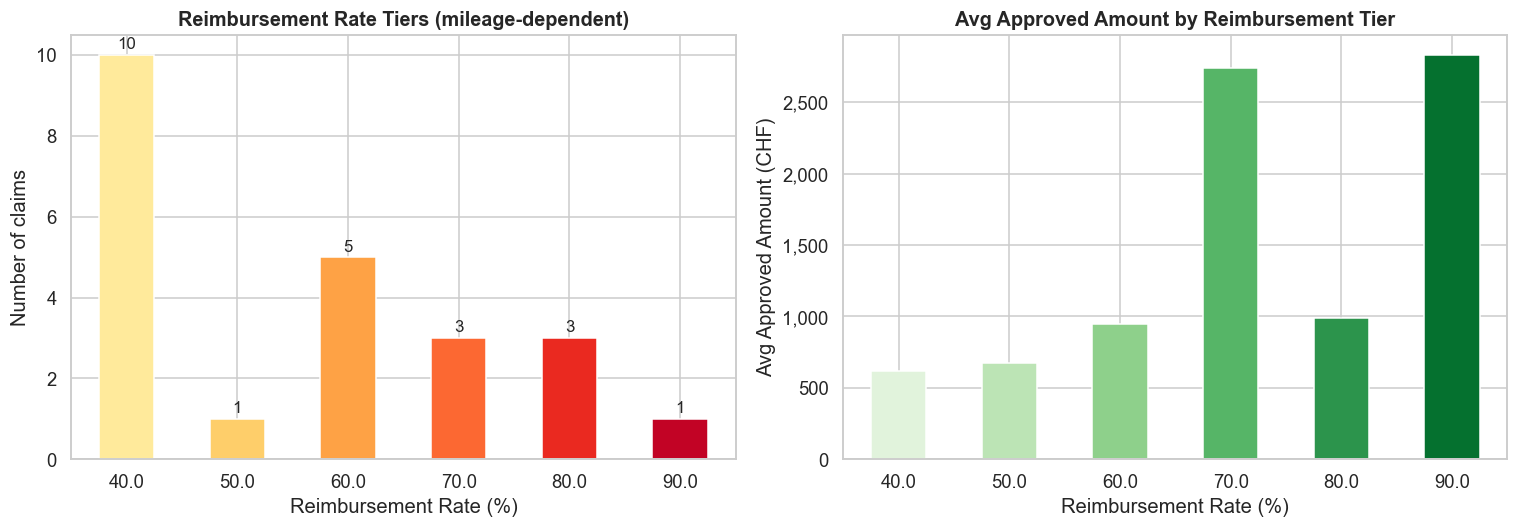

In [11]:
# --- Reimbursement rate tiers ---
has_reimb = approved[approved["reimbursement_rate_pct"].notna()].copy()
no_reimb = approved[approved["reimbursement_rate_pct"].isna()]

print(f"=== Reimbursement Rate Analysis ===")
print(f"Claims with reimbursement rate: {len(has_reimb)}")
print(f"Claims without (100% coverage or not specified): {len(no_reimb)}")
print(f"\nRate distribution:")
rate_counts = has_reimb["reimbursement_rate_pct"].value_counts().sort_index()
for rate, cnt in rate_counts.items():
    print(f"  {rate:.0f}%: {cnt} claims")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of rate tiers
rate_counts.plot.bar(ax=axes[0], color=sns.color_palette("YlOrRd", len(rate_counts)), edgecolor="white")
axes[0].set_xlabel("Reimbursement Rate (%)")
axes[0].set_ylabel("Number of claims")
axes[0].set_title("Reimbursement Rate Tiers (mileage-dependent)", fontsize=13, fontweight="bold")
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate(rate_counts.values):
    axes[0].text(i, v + 0.15, str(v), ha="center", fontsize=11)

# Average approved amount by rate tier
avg_by_rate = has_reimb.groupby("reimbursement_rate_pct")["total_approved_amount"].mean()
avg_by_rate.plot.bar(ax=axes[1], color=sns.color_palette("Greens", len(avg_by_rate)), edgecolor="white")
axes[1].set_xlabel("Reimbursement Rate (%)")
axes[1].set_ylabel("Avg Approved Amount (CHF)")
axes[1].set_title("Avg Approved Amount by Reimbursement Tier", fontsize=13, fontweight="bold")
axes[1].tick_params(axis='x', rotation=0)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

### 5c. Parts vs Labor Split

For claims with itemized data, what's the balance between parts cost and labor cost?

=== Parts vs Labor Split ===
Claims with itemized data: 38 / 42 approved

Parts approved:  CHF  30,998.39  (mean: 815.75)
Labor approved:  CHF  20,695.17  (mean: 544.61)
Total:           CHF  51,693.56
Parts share:     60.0%
Labor share:     40.0%


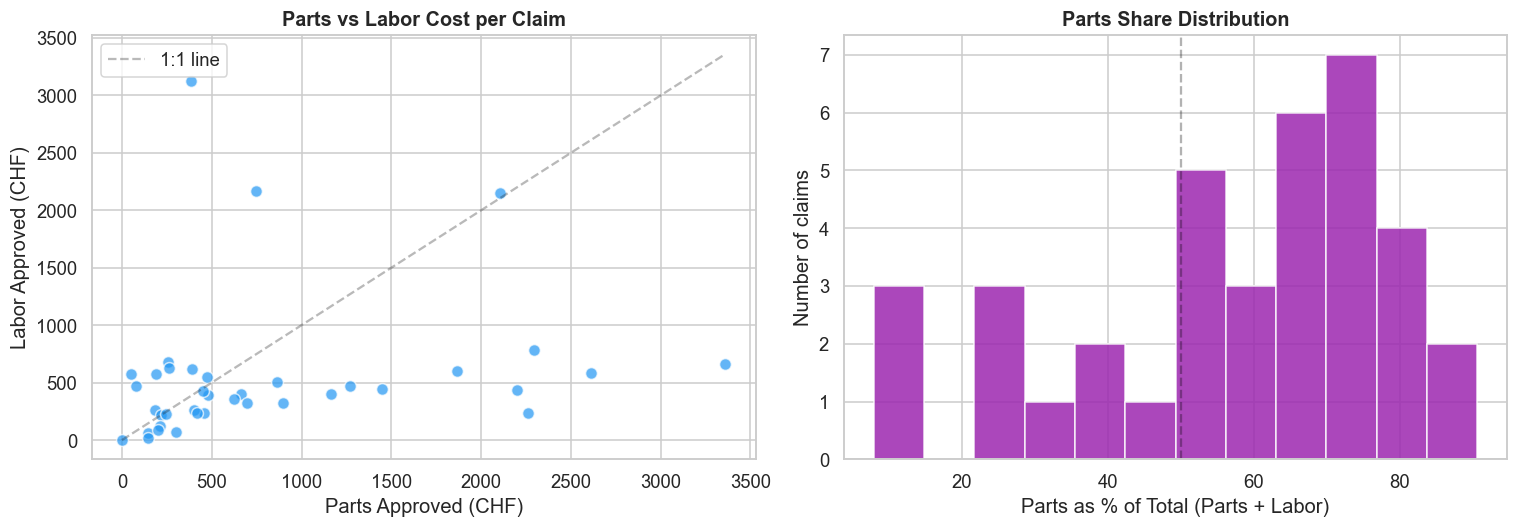


=== Estimate vs Approved ('Haircut') ===
Claims with both estimate and approved: 17
Mean haircut: 32.6%
Median haircut: 31.9%

Per claim:
  65196: est=2,367 → appr=1,689 (haircut 29%)
  65258: est=4,625 → appr=4,500 (haircut 3%)
  64687: est=2,567 → appr=2,567 (haircut 0%)
  64823: est=790 → appr=790 (haircut 0%)
  64846: est=321 → appr=321 (haircut 0%)
  64868: est=944 → appr=794 (haircut 16%)
  64873: est=3,795 → appr=3,416 (haircut 10%)
  64887: est=2,118 → appr=1,906 (haircut 10%)
  64942: est=1,630 → appr=502 (haircut 69%)
  65010: est=1,524 → appr=674 (haircut 56%)
  65037: est=1,405 → appr=957 (haircut 32%)
  65044: est=2,218 → appr=863 (haircut 61%)
  65316: est=1,194 → appr=366 (haircut 69%)
  65318: est=5,329 → appr=3,111 (haircut 42%)
  65345: est=1,465 → appr=958 (haircut 35%)
  65352: est=330 → appr=180 (haircut 45%)
  65356: est=722 → appr=162 (haircut 78%)


In [12]:
# --- Parts vs Labor analysis ---
has_split = approved[
    approved["parts_approved"].notna() & approved["labor_approved"].notna()
].copy()

print(f"=== Parts vs Labor Split ===")
print(f"Claims with itemized data: {len(has_split)} / {len(approved)} approved")
print(f"\nParts approved:  CHF {has_split['parts_approved'].sum():>10,.2f}  (mean: {has_split['parts_approved'].mean():,.2f})")
print(f"Labor approved:  CHF {has_split['labor_approved'].sum():>10,.2f}  (mean: {has_split['labor_approved'].mean():,.2f})")
total = has_split["parts_approved"].sum() + has_split["labor_approved"].sum()
print(f"Total:           CHF {total:>10,.2f}")
print(f"Parts share:     {has_split['parts_approved'].sum() / total * 100:.1f}%")
print(f"Labor share:     {has_split['labor_approved'].sum() / total * 100:.1f}%")

# Per-claim ratio
has_split["parts_pct"] = has_split["parts_approved"] / has_split["total_material_labor"] * 100
has_split["labor_pct"] = has_split["labor_approved"] / has_split["total_material_labor"] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: parts vs labor
axes[0].scatter(has_split["parts_approved"], has_split["labor_approved"],
               c="#2196F3", s=60, alpha=0.7, edgecolor="white")
max_val = max(has_split["parts_approved"].max(), has_split["labor_approved"].max())
axes[0].plot([0, max_val], [0, max_val], "k--", alpha=0.3, label="1:1 line")
axes[0].set_xlabel("Parts Approved (CHF)")
axes[0].set_ylabel("Labor Approved (CHF)")
axes[0].set_title("Parts vs Labor Cost per Claim", fontsize=13, fontweight="bold")
axes[0].legend()

# Histogram of parts % per claim
axes[1].hist(has_split["parts_pct"].dropna(), bins=12, color="#9C27B0", edgecolor="white", alpha=0.85)
axes[1].axvline(50, color="black", linestyle="--", alpha=0.3)
axes[1].set_xlabel("Parts as % of Total (Parts + Labor)")
axes[1].set_ylabel("Number of claims")
axes[1].set_title("Parts Share Distribution", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

# --- Estimate vs Approved (haircut analysis) ---
has_estimate = df[df["total_estimate"].notna() & df["total_approved_amount"].notna()].copy()
if len(has_estimate) > 0:
    has_estimate["haircut_pct"] = (
        (has_estimate["total_estimate"] - has_estimate["total_approved_amount"])
        / has_estimate["total_estimate"] * 100
    )
    print(f"\n=== Estimate vs Approved ('Haircut') ===")
    print(f"Claims with both estimate and approved: {len(has_estimate)}")
    print(f"Mean haircut: {has_estimate['haircut_pct'].mean():.1f}%")
    print(f"Median haircut: {has_estimate['haircut_pct'].median():.1f}%")
    print(f"\nPer claim:")
    for _, row in has_estimate.iterrows():
        print(f"  {row['claim_id']}: est={row['total_estimate']:,.0f} → appr={row['total_approved_amount']:,.0f} (haircut {row['haircut_pct']:.0f}%)")

## 6. Vehicle Brand Segmentation

Which brands generate the most claims? What's the approval rate and average payout by brand?

=== Claims by Vehicle Brand ===
             total_claims  approved  denied  avg_approved_amt  total_approved_amt  approval_rate
brand                                                                                           
Volkswagen             16         5      11        591.020000             2955.10           31.2
Mercedes               14         8       6       2103.903750            16831.23           57.1
Audi                    8         5       3       2209.536000            11047.68           62.5
BMW                     7         5       2       1052.894000             5264.47           71.4
Land Rover              7         5       2       1491.396000             7456.98           71.4
Peugeot                 6         2       4        739.550000             1479.10           33.3
Ford                    4         3       1       1299.033333             3897.10           75.0
Mini                    3         0       3               NaN                0.00            0.

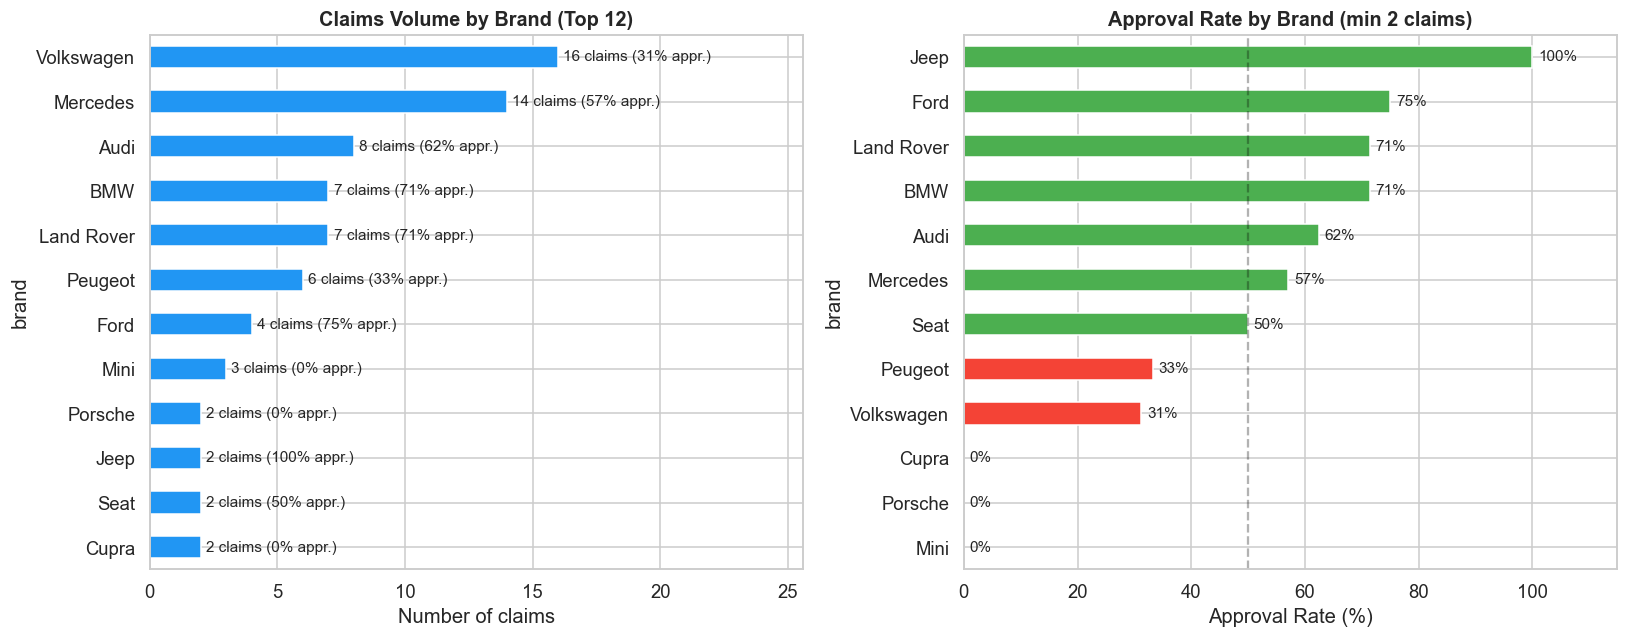

In [13]:
# --- Brand analysis ---
brand_stats = df.groupby("brand").agg(
    total_claims=("claim_id", "count"),
    approved=("decision", lambda x: (x == "APPROVED").sum()),
    denied=("decision", lambda x: (x == "DENIED").sum()),
    avg_approved_amt=("total_approved_amount", "mean"),
    total_approved_amt=("total_approved_amount", "sum"),
).sort_values("total_claims", ascending=False)

brand_stats["approval_rate"] = (brand_stats["approved"] / brand_stats["total_claims"] * 100).round(1)

print("=== Claims by Vehicle Brand ===")
print(brand_stats.to_string())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Volume by brand
top_brands = brand_stats.head(12)
colors_list = ["#4CAF50" if r > 50 else "#F44336" if r < 50 else "#FF9800" for r in top_brands["approval_rate"]]

top_brands["total_claims"].plot.barh(ax=axes[0], color="#2196F3", edgecolor="white")
axes[0].set_xlabel("Number of claims")
axes[0].set_title("Claims Volume by Brand (Top 12)", fontsize=13, fontweight="bold")
axes[0].invert_yaxis()
for i, (v, a) in enumerate(zip(top_brands["total_claims"], top_brands["approval_rate"])):
    axes[0].text(v + 0.2, i, f"{v} claims ({a:.0f}% appr.)", va="center", fontsize=10)
axes[0].set_xlim(0, top_brands["total_claims"].max() * 1.6)

# Approval rate by brand (minimum 2 claims)
min_claims = brand_stats[brand_stats["total_claims"] >= 2].sort_values("approval_rate", ascending=True)
bar_colors = ["#4CAF50" if r >= 50 else "#F44336" for r in min_claims["approval_rate"]]
min_claims["approval_rate"].plot.barh(ax=axes[1], color=bar_colors, edgecolor="white")
axes[1].set_xlabel("Approval Rate (%)")
axes[1].set_title("Approval Rate by Brand (min 2 claims)", fontsize=13, fontweight="bold")
axes[1].axvline(50, color="black", linestyle="--", alpha=0.3)
for i, v in enumerate(min_claims["approval_rate"]):
    axes[1].text(v + 1, i, f"{v:.0f}%", va="center", fontsize=10)
axes[1].set_xlim(0, 115)

plt.tight_layout()
plt.show()

=== Total Payout by Brand ===
  Mercedes        8.0 approved  total: CHF  16,831.23  avg: CHF 2,103.90
  Audi            5.0 approved  total: CHF  11,047.68  avg: CHF 2,209.54
  Land Rover      5.0 approved  total: CHF   7,456.98  avg: CHF 1,491.40
  BMW             5.0 approved  total: CHF   5,264.47  avg: CHF 1,052.89
  Ford            3.0 approved  total: CHF   3,897.10  avg: CHF 1,299.03
  Rolls-Royce     1.0 approved  total: CHF   2,995.41  avg: CHF 2,995.41
  Volkswagen      5.0 approved  total: CHF   2,955.10  avg: CHF   591.02
  Alfa Romeo      1.0 approved  total: CHF   2,829.75  avg: CHF 2,829.75
  Jeep            2.0 approved  total: CHF   2,686.41  avg: CHF 1,343.20
  Bentley         1.0 approved  total: CHF   1,522.03  avg: CHF 1,522.03
  Peugeot         2.0 approved  total: CHF   1,479.10  avg: CHF   739.55
  Skoda           1.0 approved  total: CHF     957.16  avg: CHF   957.16
  Seat            1.0 approved  total: CHF     863.15  avg: CHF   863.15
  Subaru          1.0

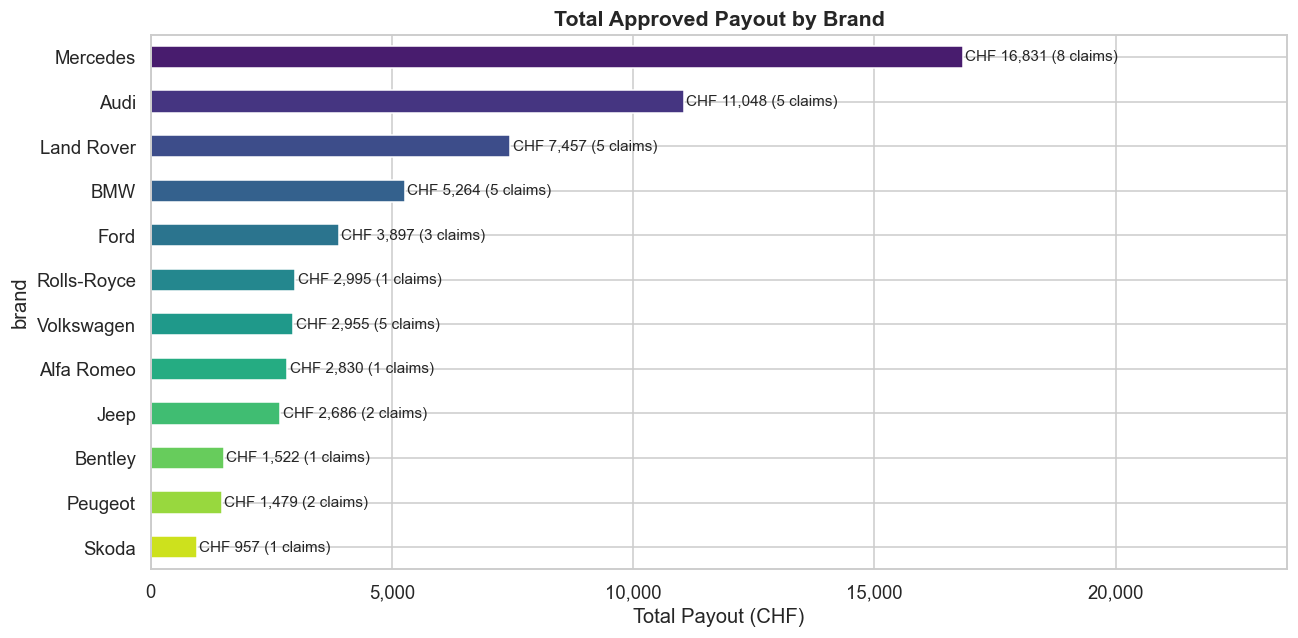

In [14]:
# --- Average approved amount by brand (brands with approved claims) ---
brand_amt = (
    df[df["decision"] == "APPROVED"]
    .groupby("brand")["total_approved_amount"]
    .agg(["mean", "sum", "count"])
    .rename(columns={"mean": "avg_payout", "sum": "total_payout", "count": "n_approved"})
    .sort_values("total_payout", ascending=False)
)
brand_amt = brand_amt[brand_amt["n_approved"] > 0]

print("=== Total Payout by Brand ===")
for brand, row in brand_amt.iterrows():
    print(f"  {brand:<15} {row['n_approved']:>2} approved  total: CHF {row['total_payout']:>10,.2f}  avg: CHF {row['avg_payout']:>8,.2f}")

fig, ax = plt.subplots(figsize=(12, 6))
brand_amt_top = brand_amt.head(12)
brand_amt_top["total_payout"].plot.barh(ax=ax, color=sns.color_palette("viridis", len(brand_amt_top)), edgecolor="white")
ax.invert_yaxis()
ax.set_xlabel("Total Payout (CHF)")
ax.set_title("Total Approved Payout by Brand", fontsize=14, fontweight="bold")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for i, (v, n) in enumerate(zip(brand_amt_top["total_payout"], brand_amt_top["n_approved"])):
    ax.text(v + 50, i, f"CHF {v:,.0f} ({n} claims)", va="center", fontsize=10)
ax.set_xlim(0, brand_amt_top["total_payout"].max() * 1.4)
plt.tight_layout()
plt.show()

## 7. Garage Analysis

Which garages submit claims, and are there repeat submitters? Geographic distribution across Swiss cities.

=== Garage Analysis ===
Claims with garage data: 81 / 84

Unique garages: 79
Repeat garages (2+ claims): 2

Repeat garages:
  AUTORAMA AG: 2 claims — {'DENIED': 1, 'APPROVED': 1}
  GARAGE DU CHATEAU D'EN BAS: 2 claims — {'DENIED': 1, 'APPROVED': 1}

=== Garage Chain / Type ===
                     claims  approved  approval_rate
garage_chain                                        
Independent              57        27           47.4
AMAG                      7         6           85.7
Emil Frey                 6         3           50.0
Mercedes-Benz (OEM)       5         3           60.0
BYMYCAR                   3         1           33.3
Audi (OEM)                1         1          100.0
Porsche (OEM)             1         0            0.0
Rolls-Royce (OEM)         1         1          100.0

=== Top Cities by Claim Volume ===
garage_city
Sion                  4
Bern                  3
Wetzikon              3
Broc                  2
Meyrin                2
Adliswil              2


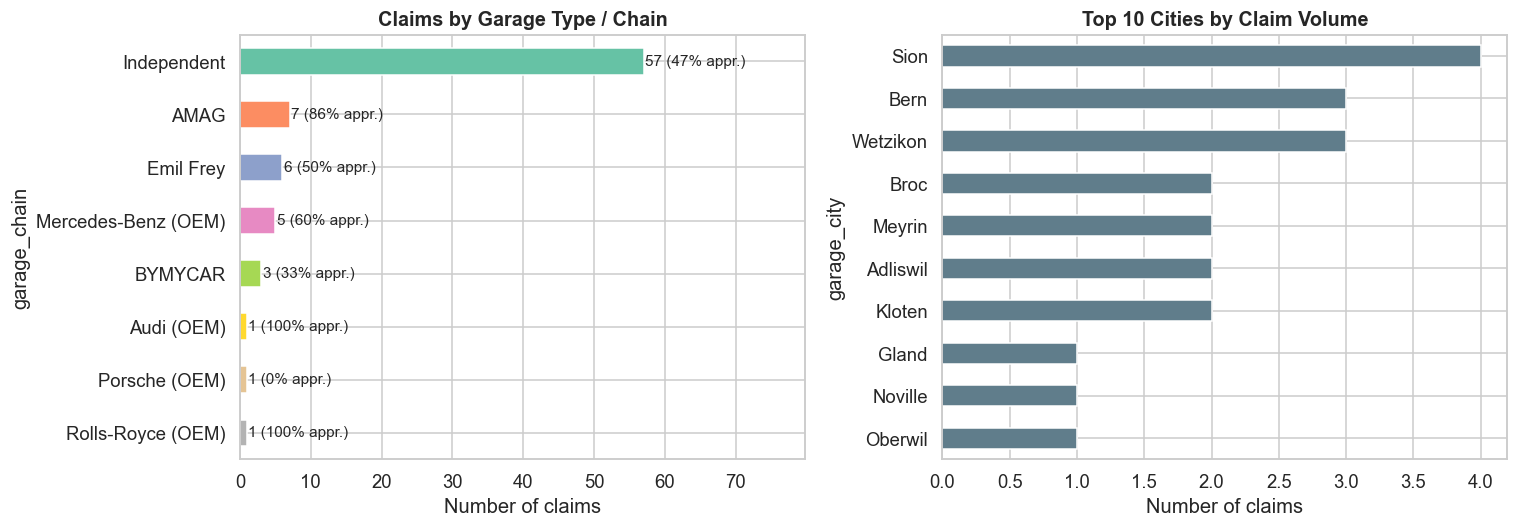

In [15]:
# --- Garage analysis ---
has_garage = df[df["garage_name"].notna()].copy()
has_garage["garage_name_norm"] = has_garage["garage_name"].str.upper().str.strip()

print(f"=== Garage Analysis ===")
print(f"Claims with garage data: {len(has_garage)} / {len(df)}")

# Repeat garages
garage_counts = has_garage["garage_name_norm"].value_counts()
repeats = garage_counts[garage_counts > 1]
print(f"\nUnique garages: {len(garage_counts)}")
print(f"Repeat garages (2+ claims): {len(repeats)}")
if len(repeats) > 0:
    print(f"\nRepeat garages:")
    for g, cnt in repeats.items():
        subset = has_garage[has_garage["garage_name_norm"] == g]
        decisions = subset["decision"].value_counts().to_dict()
        print(f"  {g}: {cnt} claims — {decisions}")

# Garage chain detection (AMAG, Emil Frey, etc.)
def detect_chain(name):
    n = name.upper()
    if "AMAG" in n:
        return "AMAG"
    if "EMIL FREY" in n or "EML FREY" in n:
        return "Emil Frey"
    if "BYMYCAR" in n:
        return "BYMYCAR"
    if "MERCEDES" in n:
        return "Mercedes-Benz (OEM)"
    if "PORSCHE" in n:
        return "Porsche (OEM)"
    if "ROLLS-ROYCE" in n:
        return "Rolls-Royce (OEM)"
    if "AUDI" in n or "CENTRE AUDI" in n:
        return "Audi (OEM)"
    return "Independent"

has_garage["garage_chain"] = has_garage["garage_name"].apply(detect_chain)
chain_stats = has_garage.groupby("garage_chain").agg(
    claims=("claim_id", "count"),
    approved=("decision", lambda x: (x == "APPROVED").sum()),
).sort_values("claims", ascending=False)
chain_stats["approval_rate"] = (chain_stats["approved"] / chain_stats["claims"] * 100).round(1)

print(f"\n=== Garage Chain / Type ===")
print(chain_stats.to_string())

# --- City analysis ---
city_counts = has_garage["garage_city"].value_counts()
print(f"\n=== Top Cities by Claim Volume ===")
print(city_counts.head(15).to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

chain_stats["claims"].plot.barh(ax=axes[0], color=sns.color_palette("Set2", len(chain_stats)), edgecolor="white")
axes[0].invert_yaxis()
axes[0].set_xlabel("Number of claims")
axes[0].set_title("Claims by Garage Type / Chain", fontsize=13, fontweight="bold")
for i, (v, a) in enumerate(zip(chain_stats["claims"], chain_stats["approval_rate"])):
    axes[0].text(v + 0.2, i, f"{v} ({a:.0f}% appr.)", va="center", fontsize=10)
axes[0].set_xlim(0, chain_stats["claims"].max() * 1.4)

top_cities = city_counts.head(10)
top_cities.plot.barh(ax=axes[1], color="#607D8B", edgecolor="white")
axes[1].invert_yaxis()
axes[1].set_xlabel("Number of claims")
axes[1].set_title("Top 10 Cities by Claim Volume", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

## 8. Language Analysis

German (de) vs French (fr) — are there meaningful differences in decision rates or claim patterns?

=== Language Analysis ===
Claims with language data: 84 / 84

decision  APPROVED  DENIED  total  approval_rate
language                                        
de              21      22     43           48.8
fr              21      18     39           53.8
it               0       2      2            0.0

=== Approved Amounts by Language ===
             mean  median       sum  count
language                                  
de        1448.52  939.98  30418.96     21
fr        1450.74  958.42  30465.59     21


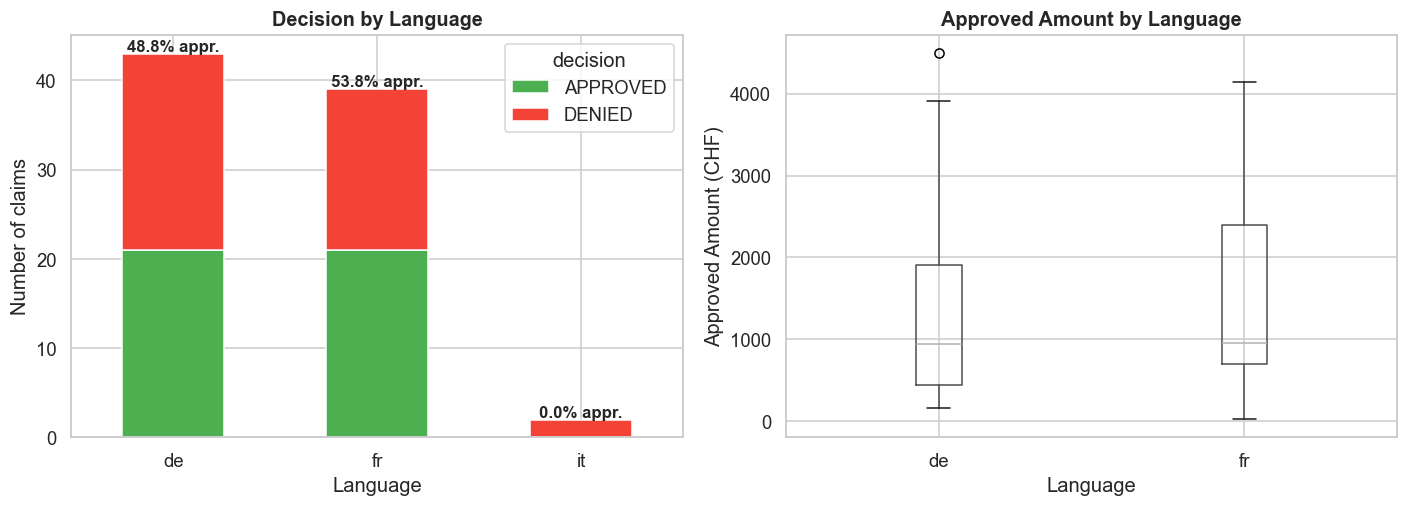

In [16]:
# --- Language analysis ---
has_lang = df[df["language"].notna()].copy()
print(f"=== Language Analysis ===")
print(f"Claims with language data: {len(has_lang)} / {len(df)}")

lang_ct = pd.crosstab(has_lang["language"], has_lang["decision"])
lang_ct["total"] = lang_ct.sum(axis=1)
lang_ct["approval_rate"] = (lang_ct["APPROVED"] / lang_ct["total"] * 100).round(1)
print(f"\n{lang_ct}")

# Average amounts by language
lang_amts = has_lang[has_lang["total_approved_amount"].notna()].groupby("language")["total_approved_amount"].agg(["mean", "median", "sum", "count"])
print(f"\n=== Approved Amounts by Language ===")
print(lang_amts.round(2))

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Stacked bar
lang_ct[["APPROVED", "DENIED"]].plot.bar(
    ax=axes[0], stacked=True,
    color=["#4CAF50", "#F44336"], edgecolor="white"
)
axes[0].set_xlabel("Language")
axes[0].set_ylabel("Number of claims")
axes[0].set_title("Decision by Language", fontsize=13, fontweight="bold")
axes[0].tick_params(axis='x', rotation=0)
for i, lang in enumerate(lang_ct.index):
    axes[0].text(i, lang_ct.loc[lang, "total"] + 0.3,
                f"{lang_ct.loc[lang, 'approval_rate']}% appr.",
                ha="center", fontsize=11, fontweight="bold")

# Box plot of amounts by language
has_lang_amt = has_lang[has_lang["total_approved_amount"].notna()]
if len(has_lang_amt) > 0:
    has_lang_amt.boxplot(column="total_approved_amount", by="language", ax=axes[1])
    axes[1].set_xlabel("Language")
    axes[1].set_ylabel("Approved Amount (CHF)")
    axes[1].set_title("Approved Amount by Language", fontsize=13, fontweight="bold")
    axes[1].get_figure().suptitle("")  # Remove auto-title

plt.tight_layout()
plt.show()

## 9. Temporal Patterns

Claim date distribution over time. Any seasonality or volume trends?

=== Temporal Analysis ===
Claims with date data: 84 / 84
Date range: 2025-10-08 to 2026-01-30

=== Claims by Month ===
decision  APPROVED  DENIED
month                     
2025-10          7       0
2025-11          4       0
2025-12         14      17
2026-01         17      25


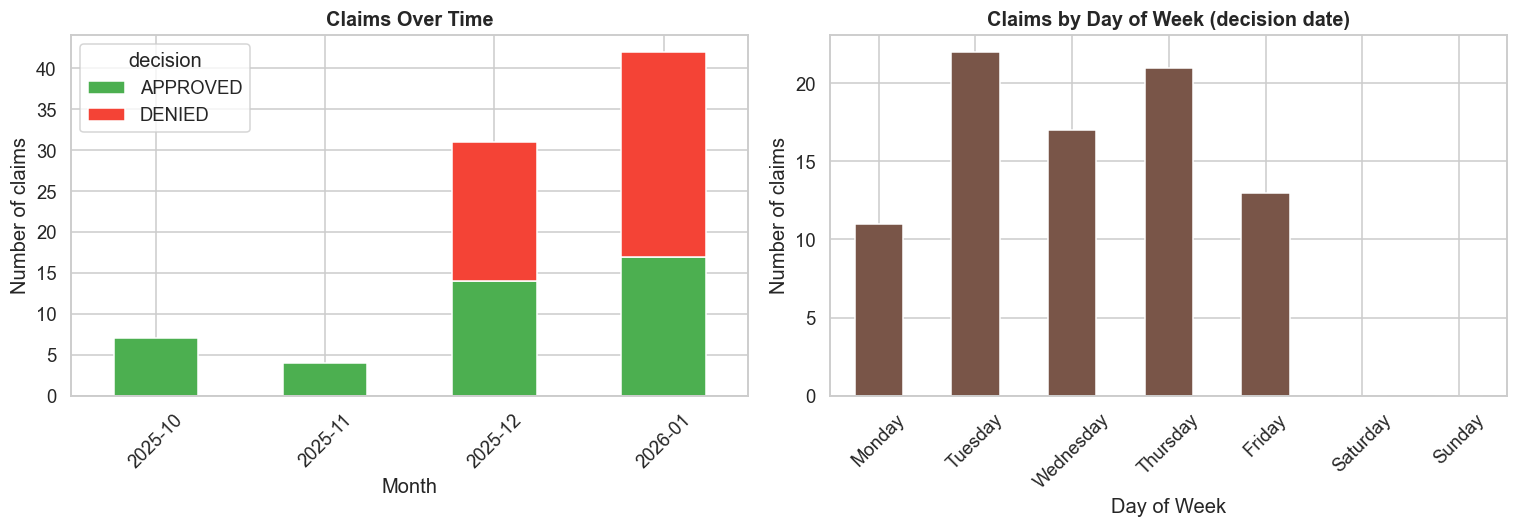

In [17]:
# --- Temporal analysis ---
has_date = df[df["date"].notna()].copy()
print(f"=== Temporal Analysis ===")
print(f"Claims with date data: {len(has_date)} / {len(df)}")
print(f"Date range: {has_date['date'].min().strftime('%Y-%m-%d')} to {has_date['date'].max().strftime('%Y-%m-%d')}")

# Claims by month
has_date["month"] = has_date["date"].dt.to_period("M")
monthly = has_date.groupby(["month", "decision"]).size().unstack(fill_value=0)

print(f"\n=== Claims by Month ===")
print(monthly)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Timeline
monthly.plot.bar(
    ax=axes[0], stacked=True,
    color=["#4CAF50", "#F44336"], edgecolor="white"
)
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Number of claims")
axes[0].set_title("Claims Over Time", fontsize=13, fontweight="bold")
axes[0].tick_params(axis='x', rotation=45)

# Day of month distribution
has_date["day_of_month"] = has_date["date"].dt.day
has_date["day_of_week"] = has_date["date"].dt.day_name()

dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_counts = has_date["day_of_week"].value_counts().reindex(dow_order).fillna(0)
dow_counts.plot.bar(ax=axes[1], color="#795548", edgecolor="white")
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Number of claims")
axes[1].set_title("Claims by Day of Week (decision date)", fontsize=13, fontweight="bold")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Cross-Dimensional: Brand x Denial Reason

Which brands are most affected by which denial categories?

=== Brand x Denial Reason (brands with 2+ denials) ===
denial_category  Consequential / root-cause damage  Mileage exclusion  \
brand                                                                   
Audi                                             0                  0   
BMW                                              1                  0   
Cupra                                            0                  0   
Land Rover                                       0                  0   
Mercedes                                         0                  1   
Mini                                             1                  0   
Peugeot                                          1                  0   
Porsche                                          0                  0   
Volkswagen                                       0                  0   

denial_category  Part not covered  Policy not valid / expired  \
brand                                                           
Audi       

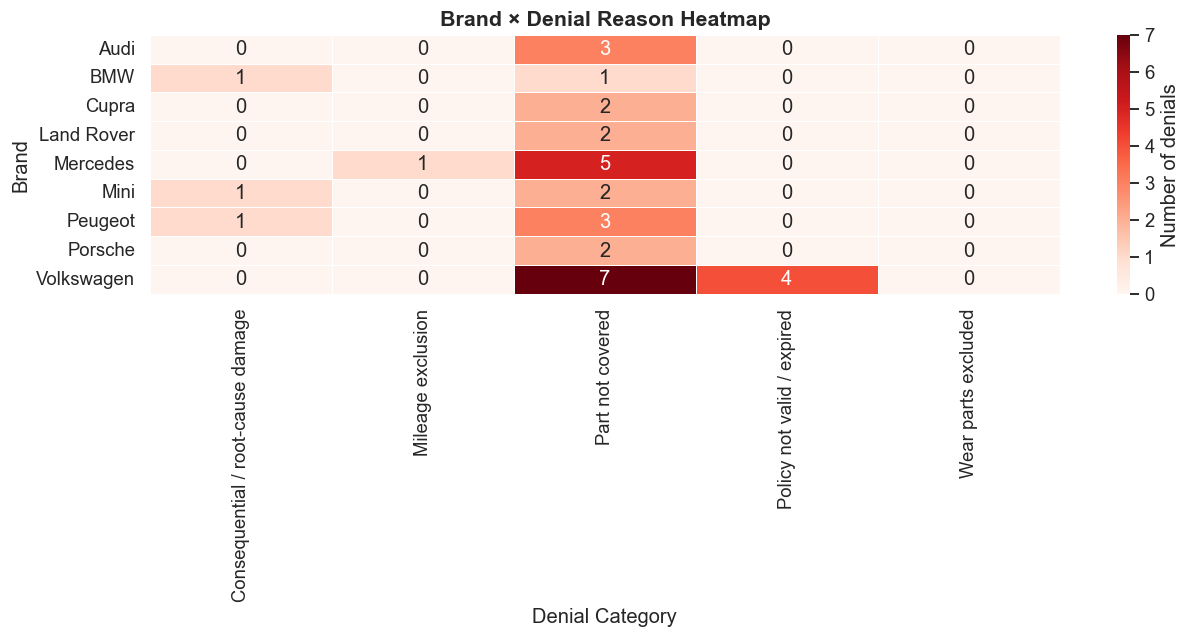

In [18]:
# --- Brand x Denial reason heatmap ---
# Merge denial categories back to main df
denied_cats = denied[["claim_id", "denial_category"]].copy()
df_merged = df.merge(denied_cats, on="claim_id", how="left")

brand_denial = pd.crosstab(
    df_merged[df_merged["decision"] == "DENIED"]["brand"],
    df_merged[df_merged["decision"] == "DENIED"]["denial_category"],
)

# Only show brands with 2+ denials
brand_denial = brand_denial[brand_denial.sum(axis=1) >= 2]

print("=== Brand x Denial Reason (brands with 2+ denials) ===")
print(brand_denial)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    brand_denial, annot=True, fmt="d", cmap="Reds", linewidths=0.5,
    ax=ax, cbar_kws={"label": "Number of denials"}
)
ax.set_title("Brand × Denial Reason Heatmap", fontsize=14, fontweight="bold")
ax.set_xlabel("Denial Category")
ax.set_ylabel("Brand")
plt.tight_layout()
plt.show()

## 11. Document Inventory

What documents come with each claim? How complete are the submissions?

=== Document Inventory ===
Claims scanned: 84
Average docs per claim: 4.9
Min docs: 3, Max docs: 13

=== Document Types Across All Claims ===
  Policy (guarantee)               86 files  (102% of claims)
  FZA (vehicle registration)       84 files  (100% of claims)
  KV (cost estimate)               83 files  (99% of claims)
  Service (book)                   72 files  (86% of claims)
  KM (mileage proof)               56 files  (67% of claims)
  Photos                           10 files  (12% of claims)
  Diagnostic (error codes)          9 files  (11% of claims)
  Other                             8 files  (10% of claims)
  Diagnostic (report)               1 files  (1% of claims)

FZA (vehicle registration): present in 84/84 claims (100%)

KV (cost estimate): present in 83/84 claims (99%)

Policy (guarantee): present in 84/84 claims (100%)

Service (book): present in 71/84 claims (85%)


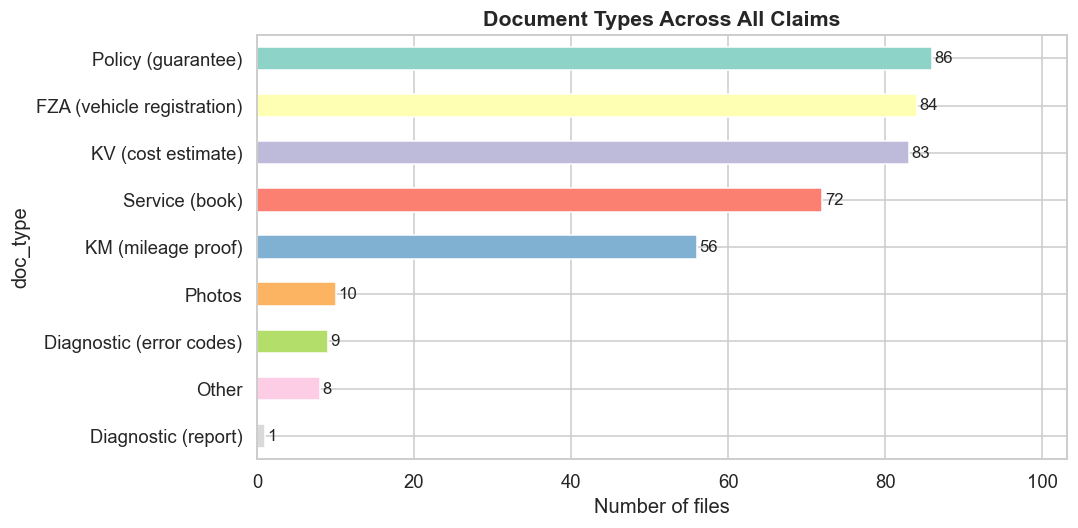

In [19]:
# --- Document inventory across all claim folders ---
import os

doc_inventory = []
for dataset_dir, dataset_name in [
    (DATA_ROOT / "nsa-motor-seed-v1/claims", "seed-v1"),
    (DATA_ROOT / "nsa-motor-eval-v1/claims", "eval-v1"),
    (DATA_ROOT / "nsa-motor-eval-v2/claims", "eval-v2"),
]:
    if not dataset_dir.exists():
        continue
    for claim_dir in sorted(dataset_dir.iterdir()):
        if not claim_dir.is_dir():
            continue
        claim_id = claim_dir.name
        files = []
        for f in claim_dir.iterdir():
            if f.is_file():
                files.append(f.name)
            elif f.is_dir():
                # e.g., Service/ directory
                for sf in f.iterdir():
                    files.append(f"{f.name}/{sf.name}")
        doc_inventory.append({
            "claim_id": claim_id,
            "dataset": dataset_name,
            "num_docs": len(files),
            "files": files,
        })

doc_df = pd.DataFrame(doc_inventory)
print(f"=== Document Inventory ===")
print(f"Claims scanned: {len(doc_df)}")
print(f"Average docs per claim: {doc_df['num_docs'].mean():.1f}")
print(f"Min docs: {doc_df['num_docs'].min()}, Max docs: {doc_df['num_docs'].max()}")

# Classify document types
def classify_doc(filename):
    fn = filename.upper()
    if fn.startswith("FZA"):
        return "FZA (vehicle registration)"
    if fn.startswith("KV") or "COST_ESTIMATE" in fn:
        return "KV (cost estimate)"
    if fn.startswith("KM") or "NACHWEIS KM" in fn:
        return "KM (mileage proof)"
    if "GUARANTEE" in fn or "POLICY" in fn:
        return "Policy (guarantee)"
    if fn.startswith("SERVICE"):
        return "Service (book)"
    if "FEHLERSPEICHER" in fn or "FEHLERCODE" in fn or "PRÜFBERICHT" in fn:
        return "Diagnostic (error codes)"
    if fn.startswith("DIAGNOSE"):
        return "Diagnostic (report)"
    if fn.startswith("FOTO") or fn.startswith("PHOTO"):
        return "Photos"
    return "Other"

all_docs = []
for _, row in doc_df.iterrows():
    for f in row["files"]:
        all_docs.append({"claim_id": row["claim_id"], "doc_type": classify_doc(f), "filename": f})

all_docs_df = pd.DataFrame(all_docs)
doc_type_counts = all_docs_df["doc_type"].value_counts()

print(f"\n=== Document Types Across All Claims ===")
for dt, cnt in doc_type_counts.items():
    pct = cnt / len(doc_df) * 100  # as % of claims
    print(f"  {dt:<30} {cnt:>4} files  ({pct:.0f}% of claims)")

# Which docs are present per claim?
doc_presence = all_docs_df.groupby("claim_id")["doc_type"].apply(set).reset_index()
core_docs = ["FZA (vehicle registration)", "KV (cost estimate)", "Policy (guarantee)", "Service (book)"]
for doc in core_docs:
    present = doc_presence["doc_type"].apply(lambda s: doc in s).sum()
    print(f"\n{doc}: present in {present}/{len(doc_df)} claims ({present/len(doc_df)*100:.0f}%)")

fig, ax = plt.subplots(figsize=(10, 5))
doc_type_counts.plot.barh(ax=ax, color=sns.color_palette("Set3", len(doc_type_counts)), edgecolor="white")
ax.invert_yaxis()
ax.set_xlabel("Number of files")
ax.set_title("Document Types Across All Claims", fontsize=14, fontweight="bold")
for i, v in enumerate(doc_type_counts.values):
    ax.text(v + 0.3, i, str(v), va="center", fontsize=11)
ax.set_xlim(0, doc_type_counts.max() * 1.2)
plt.tight_layout()
plt.show()

## 12. Key Findings Summary

Computed summary of the most actionable findings.

In [20]:
# --- Computed summary ---
total = len(df)
n_approved = (df["decision"] == "APPROVED").sum()
n_denied = (df["decision"] == "DENIED").sum()
total_payout = df["total_approved_amount"].sum()
avg_payout = df[df["decision"] == "APPROVED"]["total_approved_amount"].mean()

# Top denial category
top_denial_cat = cat_counts.index[0]
top_denial_pct = cat_counts.values[0] / n_denied * 100

# Top denied parts
top3_parts = part_df.head(3)["part"].tolist()

# Top brand by volume
top_brand = df["brand"].value_counts().index[0]
top_brand_count = df["brand"].value_counts().values[0]

# Language coverage
n_with_lang = df["language"].notna().sum()
n_with_garage = df["garage_name"].notna().sum()
n_with_date = df["date"].notna().sum()

# Parts vs labor
n_with_split = df[df["parts_approved"].notna() & df["labor_approved"].notna()].shape[0]

print("=" * 70)
print("  KEY FINDINGS — NSA Motor Guarantee Claims (n=84)")
print("=" * 70)

print(f"""
1. DECISION SPLIT
   {n_approved} approved ({n_approved/total*100:.0f}%) vs {n_denied} denied ({n_denied/total*100:.0f}%)
   → Roughly 50/50 split — half of all claims submitted get rejected.

2. WHY CLAIMS GET DENIED
   #{1} reason: "{top_denial_cat}" — accounts for {top_denial_pct:.0f}% of denials
   → Garages are overwhelmingly submitting claims for parts the policy
     doesn't cover. This is an education / pre-screening opportunity.

3. MOST COMMONLY DENIED PARTS
   Top 3: {', '.join(top3_parts)}
   → Emissions (EGR, AdBlue, DPF), electronics (software, wiring),
     and seals/gaskets are the biggest coverage gaps.

4. FINANCIAL PROFILE
   Total payout across dataset: CHF {total_payout:,.0f}
   Average approved payout: CHF {avg_payout:,.0f}
   CHF 150 is the most common deductible floor.
   Mileage-dependent reimbursement tiers (40-90%) significantly
   reduce payouts on high-mileage vehicles.

5. BRAND CONCENTRATION
   Top brand: {top_brand} ({top_brand_count} claims, {top_brand_count/total*100:.0f}% of all claims)
   German premium brands (VW, Mercedes, BMW, Audi) dominate the portfolio.

6. AUTOMATION OPPORTUNITY
   - Denials for "part not covered" are highly rule-based (lookup part → check coverage list)
   - These represent the majority of all denials
   - Pre-screening at submission time could prevent ~{top_denial_pct:.0f}% of denied claims
     from ever being submitted, saving processing time for both sides.
""")

print("=" * 70)
print("  DATA COVERAGE")
print("=" * 70)
print(f"""
- Language:       {n_with_lang}/{total} claims ({n_with_lang/total*100:.0f}%)
- Date:           {n_with_date}/{total} claims ({n_with_date/total*100:.0f}%)
- Garage:         {n_with_garage}/{total} claims ({n_with_garage/total*100:.0f}%)
- Parts/Labor:    {n_with_split}/{n_approved} approved claims ({n_with_split/n_approved*100:.0f}%)
- Languages:      de, fr, it (Italian in eval-v2 only — 2 claims)
- Vehicle names are inconsistently formatted (e.g., "FordFOCUS", "VW T6")
- Denial reasons are free-text in DE/FR — automated classification covers
  ~{(len(denied) - len(no_parts)) / len(denied) * 100:.0f}% of cases
- Date formats vary (DD.MM.YYYY vs DD/MM/YYYY) — normalized in this analysis
""")

  KEY FINDINGS — NSA Motor Guarantee Claims (n=84)

1. DECISION SPLIT
   42 approved (50%) vs 42 denied (50%)
   → Roughly 50/50 split — half of all claims submitted get rejected.

2. WHY CLAIMS GET DENIED
   #1 reason: "Part not covered" — accounts for 76% of denials
   → Garages are overwhelmingly submitting claims for parts the policy
     doesn't cover. This is an education / pre-screening opportunity.

3. MOST COMMONLY DENIED PARTS
   Top 3: Software update, Gaskets / seals, EGR valve / system
   → Emissions (EGR, AdBlue, DPF), electronics (software, wiring),
     and seals/gaskets are the biggest coverage gaps.

4. FINANCIAL PROFILE
   Total payout across dataset: CHF 60,885
   Average approved payout: CHF 1,450
   CHF 150 is the most common deductible floor.
   Mileage-dependent reimbursement tiers (40-90%) significantly
   reduce payouts on high-mileage vehicles.

5. BRAND CONCENTRATION
   Top brand: Volkswagen (16 claims, 19% of all claims)
   German premium brands (VW, Merced